In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score
from src.utils import get_final_predictions, load_embedding
from src.data import DataProcessing
import tensorflow as tf
import src.data as my_data

tf.logging.set_verbosity(tf.logging.ERROR)  # suppress some deprecation warnings

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

/cluster/apps/python/3.6.4/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0522 18:08:35.359369 47033619180992 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
data_processing = DataProcessing()

In [3]:
data_directory = './data/'

data_processing.train_data, data_processing.train_classes = \
        data_processing.read_data_train(os.path.join(data_directory, 'train_stories.csv'))
data_processing.val_data, data_processing.val_classes = \
    data_processing.read_data_val(os.path.join(data_directory,
                                               'cloze_test_val__spring2016 - cloze_test_ALL_val.csv'))

In [4]:
data_processing.construct_vocab()

print('vocabulary_size', len(data_processing.vocab))

Total distinct tokens found: 17268
vocabulary_size 17270


In [18]:
# parameters

BATCH_SIZE = 64
embedding_size = 300

units = 1024
num_labels = 2
NUM_EPOCHS = 2
NEGATIVE_SAMPLING = 3

NUM_SAMPLES_TRAINING = data_processing.num_samples_training
NUM_SAMPLES_VALIDATION = data_processing.num_samples_val

In [32]:
tf.reset_default_graph()

In [33]:
train_context, train_last_sentence, train_y = data_processing.create_dataset(0, BATCH_SIZE, NEGATIVE_SAMPLING)

test_context, test_last_sentence, test_y = data_processing.create_dataset(1, BATCH_SIZE, 0)

In [34]:
print(train_context)
print(train_last_sentence)
print(train_y)
print()
print(test_context)
print(test_last_sentence)
print(test_y) 

Tensor("IteratorGetNext:0", shape=(?, 80), dtype=int32)
Tensor("IteratorGetNext:1", shape=(?, 20), dtype=int32)
Tensor("IteratorGetNext:2", shape=(?,), dtype=int32)

Tensor("IteratorGetNext_1:0", shape=(?, 80), dtype=int32)
Tensor("IteratorGetNext_1:1", shape=(?, 20), dtype=int32)
Tensor("IteratorGetNext_1:2", shape=(?,), dtype=int32)


In [35]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.enc_units))

In [36]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        
        self.W1 = tf.keras.layers.Dense(units, name='Dense_1')
        self.W2 = tf.keras.layers.Dense(units, name='Dense_2')
        self.V = tf.keras.layers.Dense(1, name='Dense_3')
    
    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, hidden_size)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [37]:
class DenseLayerWithSoftmax(tf.keras.Model):
    def __init__(self, layers, num_classes, dropout_keep_proba=0.9, activation=tf.nn.relu):
        super(DenseLayerWithSoftmax, self).__init__()
        
        self.dense_layers = []
        self.dropout_keep_proba = dropout_keep_proba
        self.num_classes = num_classes
        
        for i, layer_size in enumerate(layers):
            self.dense_layers.append(tf.keras.layers.Dense(layer_size, name='DenseLayer_' + str(i), use_bias=True, activation=tf.nn.relu))
    
        self.final_layer = tf.keras.layers.Dense(self.num_classes, name='DenseLayer_final', use_bias=True)
    
    def call(self, input_, input_labels):
        
        logits = input_
        
        for layer in self.dense_layers:
            logits = layer(logits)
            logits = tf.nn.dropout(logits, keep_prob=self.dropout_keep_proba)

        logits = self.final_layer(logits)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(input_labels, depth=self.num_classes, dtype=tf.float32)
        
        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))

        per_example_loss = - tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return predicted_labels, loss, log_probs

In [38]:
def weight_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer()):
    """
    Creates a variable with a specified initializer
    """
    variable = tf.get_variable(name, initializer=initializer(shape))
    return variable

## LSDSem 2017: Exploring Data Generation Methods for the Story Cloze Test (https://aclweb.org/anthology/W17-0908)

Separate networks for encoder and decoder. Concatenate their states and feed forward.

In [39]:
class TwoRNNSConcatOutputs(tf.keras.Model):
    def __init__(self, units, vocabulary_size, num_classes=2,
                 fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu):
        super(TwoRNNSConcatOutputs, self).__init__()
        
        self.units = units
        
        self.input_embeddings = weight_variable('input_embeddings', [vocabulary_size, embedding_size])
        
        self.encoder = Encoder(self.units)
        self.decoder = Encoder(self.units)
        
        self.feed_foward = DenseLayerWithSoftmax(fc_layers, num_classes, 
                                                 dropout_keep_proba=dropout_keep_proba, activation=activation)
        
    def call(self, input_context, input_last_sentence, input_labels):

        context_embedding = tf.nn.embedding_lookup(self.input_embeddings, input_context,
                                                   name='sentence_embedding')
        
        last_sentence_embedding = tf.nn.embedding_lookup(self.input_embeddings, input_last_sentence,
                                                   name='sentence_embedding')
        
        # pass through encoder
        sample_hidden_enc = self.encoder.initialize_hidden_state(tf.shape(context_embedding)[0])
        sample_output_enc, sample_hidden_enc = self.encoder(context_embedding, sample_hidden_enc)
        
        # pass through decoder 
#         sample_hidden_dec = self.decoder.initialize_hidden_state(tf.shape(last_sentence_embedding)[0])
        sample_output_dec, sample_hidden_dec = self.decoder(last_sentence_embedding, sample_hidden_enc)
        
        # concatenate last two states
        concatenated_outputs = tf.concat([sample_hidden_enc, sample_hidden_dec], axis=1)
        
        return self.feed_foward(concatenated_outputs, input_labels)

In [40]:
fc_layers = [128]

vocabulary_size = len(data_processing.vocab)

twoRNNSConcatOutputs = TwoRNNSConcatOutputs(units, vocabulary_size, num_classes=2, fc_layers=[])

predicted_labels_train, loss_train, log_probs_train = twoRNNSConcatOutputs(train_context, train_last_sentence, train_y)
predicted_labels_test, loss_test, log_probs_test = twoRNNSConcatOutputs(test_context, test_last_sentence, test_y)

## MY attention

In [41]:
# class MyAttention(tf.keras.Model):
#     def __init__(self, units, attention_units=10, num_classes=2, fc_layers=[], dropout_keep_proba=0.9, activation=tf.nn.relu):
#         super(AttentionRNN, self).__init__()
        
#         self.units = units
        
#         self.input_embeddings = weight_variable('input_embeddings', [vocabulary_size, embedding_size])
        
#         self.encoder = Encoder(self.units)
#         self.decoder = Encoder(self.units)
        
#         self.attention_layer = BahdanauAttention(attention_units)
#         self.feed_foward = DenseLayerWithSoftmax(fc_layers, num_classes, 
#                                                  dropout_keep_proba=dropout_keep_proba, activation=activation)
        
#     def call(self, input_context, input_last_sentence, input_labels):

#         context_embedding = tf.nn.embedding_lookup(self.input_embeddings, input_context,
#                                                    name='sentence_embedding')
        
#         last_sentence_embedding = tf.nn.embedding_lookup(self.input_embeddings, input_last_sentence,
#                                                    name='sentence_embedding')
#         # sample input
#         sample_hidden = self.encoder.initialize_hidden_state(tf.shape(story_embedding)[0])
#         sample_output, sample_hidden = self.encoder(story_embedding, sample_hidden)
        
#         sentence_to_check = tf.reshape(sample_output[:, -1, :], [-1, self.units])
#         first_four_sentences = sample_output[:, :4, :]
        
#         attention_result, attention_weights = self.attention_layer(sentence_to_check, first_four_sentences)
        
#         return self.feed_foward(attention_result, input_labels)

## TRAIN

In [42]:
import math 

update_lr_every = int((math.ceil(NUM_SAMPLES_TRAINING / (BATCH_SIZE / (NEGATIVE_SAMPLING + 1))) * NUM_EPOCHS) / 20)

global_step  = tf.Variable(0, trainable=False, name="global_step")
print(update_lr_every)

# learning rate 1e-3 for most models
learning_rate = tf.train.exponential_decay(
  2e-4,                 # Base learning rate.
  global_step,  # Current index into the dataset.
  update_lr_every,          # Decay step.
  0.96,                # Decay rate.
  staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, variables = zip(*optimizer.compute_gradients(loss_train))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
train_op = optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

# train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_train, global_step=global_step)

551


In [43]:
from tqdm import trange
import math
import sys


with tf.Session() as sess:
    
    load_embedding(sess, data_processing.vocab, twoRNNSConcatOutputs.input_embeddings,
                   '/cluster/project/infk/courses/machine_perception_19/Sasglentamekaiedo/glove.6B.300d.txt',
                   embedding_size)
#                    embedding_size, len(data_processing.vocab))
    
    tf.global_variables_initializer().run()
    
    losses = []
    
    def get_predictions(predicted_labels, y, log_probs, number_of_steps, num_samples, phase):
        predictions = []
        true_labels = []
        log_probs_total = []
        
        desc = 'predictions on ' + str(phase)
        desc = desc.ljust(26)
        with trange(number_of_steps, desc=desc) as t:
            for i in t:
                # display training status
                epoch_cur = i * BATCH_SIZE // num_samples
                iter_cur = (i * BATCH_SIZE ) % num_samples
                t.set_postfix(epoch=epoch_cur,iter_percent="%d %%"%(iter_cur/float(NUM_SAMPLES_VALIDATION)*100) )
                
                predictions_batch, true_labels_batch, log_probs_batch = sess.run([predicted_labels, y, log_probs])

                predictions.append(predictions_batch)
                true_labels.append(true_labels_batch)
                log_probs_total.append(log_probs_batch)
        
        return np.concatenate(predictions, axis=0).reshape(-1), np.concatenate(true_labels, axis=0).reshape(-1), \
                    np.concatenate(log_probs_total, axis=0).reshape(-1, 2)
    
#     with trange(math.ceil(NUM_SAMPLES_TRAINING / (BATCH_SIZE / (NEGATIVE_SAMPLING + 1))) * NUM_EPOCHS) as t:
#     if train_on_validation:
#         number_of_steps = math.ceil(NUM_SAMPLES_TRAINING / BATCH_SIZE)
#         batch_index = BATCH_SIZE 
#     else:
    number_of_steps = math.ceil(NUM_SAMPLES_TRAINING / (BATCH_SIZE / (NEGATIVE_SAMPLING + 1)))
    batch_index = BATCH_SIZE / (NEGATIVE_SAMPLING + 1)

    desc = 'training phase'.ljust(26)
    with trange(number_of_steps * NUM_EPOCHS, desc=desc) as t:
        last_epoch = 0
        for i in t:
            # display training status
            epoch_cur = (i * batch_index) // NUM_SAMPLES_TRAINING
            iter_cur = (i * batch_index) % NUM_SAMPLES_TRAINING
            t.set_postfix(epoch=epoch_cur,iter_percent="%d %%"%(iter_cur/float(NUM_SAMPLES_TRAINING)*100) )
            
            _, _, lt = sess.run([train_op, global_step, loss_train])

            losses.append(lt)
             
            if epoch_cur > last_epoch:
                last_epoch = epoch_cur
                predictions_test, labels_test, probabilities_test = get_predictions(predicted_labels_test, test_y, log_probs_test, math.ceil(NUM_SAMPLES_VALIDATION / BATCH_SIZE), NUM_SAMPLES_VALIDATION, 'validation')
                print(f'Raw predictions validation score {accuracy_score(labels_test, predictions_test):.3f} and unified {accuracy_score(labels_test[::2], get_final_predictions(probabilities_test, threshold=1)):.3f}')
            
    predictions_train, labels_train, probabilities_train = get_predictions(predicted_labels_train, train_y, log_probs_train, number_of_steps, NUM_SAMPLES_TRAINING, 'training')
    predictions_test, labels_test, probabilities_test = get_predictions(predicted_labels_test, test_y, log_probs_test, math.ceil(NUM_SAMPLES_VALIDATION / BATCH_SIZE), NUM_SAMPLES_VALIDATION, 'validation')

Loading glove model
Done. 400000  words loaded!
<unk> not in embedding file
<pad> not in embedding file
hadn not in embedding file
00pm not in embedding file
17266 words out of 17270 could be loaded


training phase            :  30%|███       | 3330/11022 [28:57<1:06:04,  1.94it/s, epoch=0, iter_percent=60 %]


KeyboardInterrupt: 

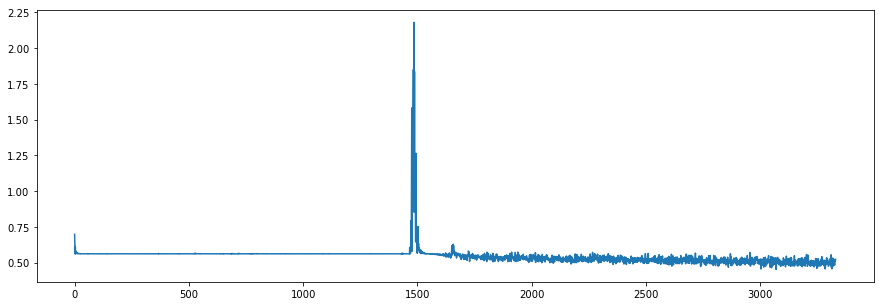

In [44]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 5


plt.plot(losses)

In [ ]:
print(accuracy_score(labels_train, predictions_train))
print(accuracy_score(labels_test, predictions_test))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_train, predictions_train)

In [ ]:
confusion_matrix(labels_test, predictions_test)

In [ ]:
accuracy_score(labels_test[::2], get_final_predictions(probabilities_test, threshold=1))

In [ ]:
np.exp(probabilities_train[:10])